# Computer Vision Final Project

## Team Member
- Junhua Liang (jl11998)
- Bichi Wu (bw2264)

In [22]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive
!rm -rf color
!rm -rf gray
!rm -rf fresh
!unzip color
!unzip gray
!unzip fresh

Streaming output truncated to the last 5000 lines.
  inflating: gray/4902.jpg           
  inflating: gray/336.jpg            
  inflating: gray/450.jpg            
  inflating: gray/6873.jpg           
  inflating: gray/4123.jpg           
  inflating: gray/2552.jpg           
  inflating: gray/3894.jpg           
  inflating: gray/6734.jpg           
  inflating: gray/6052.jpg           
  inflating: gray/2234.jpg           
  inflating: gray/4645.jpg           
  inflating: gray/4889.jpg           
  inflating: gray/2220.jpg           
  inflating: gray/4651.jpg           
  inflating: gray/1729.jpg           
  inflating: gray/6046.jpg           
  inflating: gray/6720.jpg           
  inflating: gray/4137.jpg           
  inflating: gray/3658.jpg           
  inflating: gray/2546.jpg           
  inflating: gray/5229.jpg           
  inflating: gray/3880.jpg           
  inflating: gray/6708.jpg           
  inflating: gray/1067.jpg           
  inflating: gray/3670.jpg           

## Data Processing

In [3]:
import os

import matplotlib.pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
from PIL import Image
from skimage import color

In [23]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

num_epoches = 80
batch_size = 32
lr = 0.01
home = '/content/drive/MyDrive/'
landscape_home = '/content/drive/MyDrive/landscape/'
fresh_home = '/content/drive/MyDrive/fresh/'

cuda


In [24]:
class FreshDataset(Dataset):
    def __init__(self, dir, test=False):
        self.dir = dir
        self.gray_path = dir + 'gray/'
        self.color_path = dir + 'color/'
        self.test_path = dir + 'test/'
        self.test = test

        self.path = []
        if test:
            for _, _, files in os.walk(self.test_path):
                for file in files:
                    self.path.append(file)
        else:
            for root, dirs, _ in os.walk(self.gray_path):
                for dir in dirs:
                    for _, _, files in os.walk(self.gray_path+dir):
                        for file in files:
                            self.path.append(dir + '/' + file)

    def __len__(self):
        return len(self.path)

    def __getitem__(self, idx):
        img_name = self.path[idx]
        if self.test:
            image = torchvision.io.read_image(self.test_path + img_name)
        else:
            image = torchvision.io.read_image(self.gray_path + img_name)
        image = image.unsqueeze(0)
        image = F.interpolate(image,(160,160))
        image = image.squeeze(0)
        image = image.permute(1,2,0)
        image = image.repeat(1,1,3)
        image = image.permute(2,0,1)
        image = torch.tensor(color.rgb2lab(image.permute(1,2,0)/255))
        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        image = image.permute(2,0,1)
        image = image[:1, :, :] # grayscale channel as input
        if self.test:
            return image

        label = torchvision.io.read_image(self.color_path + img_name)
        label = label.unsqueeze(0)
        label = F.interpolate(label, (160,160))
        label = label.squeeze(0)
        label = label.permute(1,2,0)
        label = label.permute(2,0,1)
        label = torch.tensor(color.rgb2lab(label.permute(1,2,0)/255))
        label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        label = label.permute(2,0,1)
        label = label[1:, :, :] # a, b channels as label

        return image, label

In [25]:
class LandscapeDataset(Dataset):
    def __init__(self, dir):
        self.dir = dir
        self.gray_path = dir + 'gray/'
        self.color_path = dir + 'color/'

    def __len__(self):
        return len(os.listdir(self.gray_path))

    def __getitem__(self, idx):
        img_name = str(idx) + '.jpg'
        image = torchvision.io.read_image(self.gray_path + img_name)
        image = image.unsqueeze(0)
        image = F.interpolate(image,(160,160))
        image = image.squeeze(0)
        image = image.permute(1,2,0)
        image = image.repeat(1,1,3)
        image = image.permute(2,0,1)
        label = torchvision.io.read_image(self.color_path + img_name)
        label = label.unsqueeze(0)
        label = F.interpolate(label, (160,160))
        label = label.squeeze(0)
        label = label.permute(1,2,0)
        label = label.permute(2,0,1)
        image = torch.tensor(color.rgb2lab(image.permute(1,2,0)/255))
        label = torch.tensor(color.rgb2lab(label.permute(1,2,0)/255))

        image = (image + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])
        label = (label + torch.tensor([0, 128, 128])) / torch.tensor([100, 255, 255])

        image = image.permute(2,0,1)
        label = label.permute(2,0,1)
        image = image[:1, :, :] # grayscale channel as input
        label = label[1:, :, :] # a, b channels as label

        return image, label

In [26]:
def concat_lab_to_rgb(img_gray, img_ab):
    img_lab = torch.cat((img_gray, img_ab), dim=0).permute(1,2,0)
    img_lab = img_lab * torch.tensor([100,255,255]) - torch.tensor([0,128,128])
    img_rgb = color.lab2rgb(img_lab.detach().numpy())
    return img_rgb

In [27]:
def show_sample(loader, rows=2, cols=3):
    gray, color = next(iter(loader))
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols + 1):
        figure.add_subplot(rows, cols, i)
        plt.title('Color')
        plt.imshow(concat_lab_to_rgb(gray[i], color[i]))
        plt.axis("off")
        figure.add_subplot(rows, cols, i + cols)
        plt.title('Gray')
        plt.imshow(gray[i].permute(1, 2, 0).squeeze(axis=2), cmap='gray')
        plt.axis("off")
    plt.show()

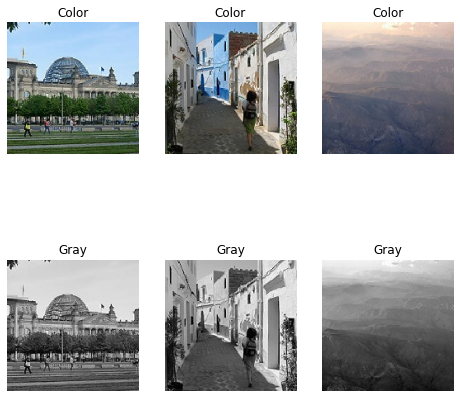

In [28]:
landscape = LandscapeDataset(landscape_home)
train_set_size = (int)(0.8 * len(landscape))
val_set_size = (int)(0.1 * len(landscape))
test_set_size = len(landscape) - train_set_size - val_set_size
landscape_train, landscape_val, landscape_test = torch.utils.data.random_split(landscape, [train_set_size, val_set_size, test_set_size])
landscape_train_loader = torch.utils.data.DataLoader(landscape_train, batch_size=batch_size, shuffle=True)
landscape_val_loader = torch.utils.data.DataLoader(landscape_val, batch_size=batch_size, shuffle=False)
landscape_test_loader = torch.utils.data.DataLoader(landscape_test, batch_size=batch_size, shuffle=False)
show_sample(landscape_train_loader) 

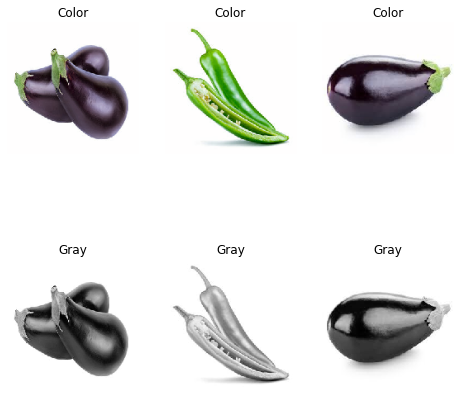

In [29]:
freshdata = FreshDataset(fresh_home)
freshdata_test = FreshDataset(fresh_home, test=True)
freshdata_train_set_size = (int)(0.8 * len(freshdata))
freshdata_val_set_size = len(freshdata) - freshdata_train_set_size
freshdata_train, freshdata_val = torch.utils.data.random_split(freshdata, [freshdata_train_set_size, freshdata_val_set_size])
fresh_train_loader = torch.utils.data.DataLoader(freshdata_train, batch_size=batch_size, shuffle=True)
fresh_val_loader = torch.utils.data.DataLoader(freshdata_val, batch_size=batch_size, shuffle=False)
fresh_test_loader = torch.utils.data.DataLoader(freshdata_test, batch_size=batch_size)
show_sample(fresh_train_loader) 

## Model

In [12]:
def conv3x3(in_channels, out_channels, stride=1):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                    stride=stride, padding=1, bias=False)

class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        
    def forward(self, x):
        residual = x
        if self.downsample is not None:
            residual = self.downsample(x)
            
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += residual
        out = self.relu(out)
        return out

class Encoder(nn.Module):
    def __init__(self, block, layers):
        super(Encoder, self).__init__()
        self.in_channels = 64
        self.conv = conv3x3(1, 64)
        self.bn = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self.make_layer(block, 64,  num_blocks=layers[0], stride=2)
        self.layer2 = self.make_layer(block, 128, num_blocks=layers[1], stride=2)
        
    def make_layer(self, block, out_channels, num_blocks, stride=1):
        downsample = None
        if (stride != 1) or (self.in_channels != out_channels):
            downsample = nn.Sequential(
                conv3x3(self.in_channels, out_channels, stride=stride),
                nn.BatchNorm2d(out_channels)
            )
            
        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels
        for i in range(1, num_blocks):
            layers.append(block(out_channels, out_channels))
            
        return nn.Sequential(*layers)
    
    def forward(self, x):
        out = self.conv(x)
        out = self.bn(out)
        out = self.relu(out)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [30]:
class ColorizationNet(nn.Module):
  def __init__(self):
    super(ColorizationNet, self).__init__()
    self.encoder = Encoder(Block, [2, 2])

    self.conv1 = nn.Sequential(
      nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(128),
      nn.ReLU(),
    )

    self.up_sample_1 = nn.Upsample(scale_factor=2)

    self.conv2 = nn.Sequential(
      nn.Conv2d(128, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )

    self.conv3 = nn.Sequential(
      nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(64),
      nn.ReLU(),
    )

    self.up_sample_2 = nn.Upsample(scale_factor=2)

    self.conv4 = nn.Sequential(  
      nn.Conv2d(64, 32, kernel_size=3, stride=1, padding=1),
      nn.BatchNorm2d(32),
      nn.ReLU(),
    )

    self.conv5 = nn.Conv2d(32, 2, kernel_size=3, stride=1, padding=1)

  def forward(self, input):
    out = self.encoder(input)
    out = self.conv1(out)
    out = self.up_sample_1(out)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.up_sample_2(out)
    out = self.conv4(out)
    out = self.conv5(out)
    return out

## Training

In [31]:
def show_curve(y, title):
    xs = np.array(range(len(y)))
    ys = np.array(y)
    plt.plot(xs, ys)
    plt.title("{} curve".format(title))
    plt.xlabel("epoch")
    plt.ylabel(title)
    plt.savefig(home+title+'.jpg')
    plt.show()

In [15]:
model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.0)
summary(model, input_size=(1, 160, 160))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 160, 160]             576
       BatchNorm2d-2         [-1, 64, 160, 160]             128
              ReLU-3         [-1, 64, 160, 160]               0
            Conv2d-4           [-1, 64, 80, 80]          36,864
       BatchNorm2d-5           [-1, 64, 80, 80]             128
            Conv2d-6           [-1, 64, 80, 80]          36,864
       BatchNorm2d-7           [-1, 64, 80, 80]             128
            Conv2d-8           [-1, 64, 80, 80]          36,864
       BatchNorm2d-9           [-1, 64, 80, 80]             128
             ReLU-10           [-1, 64, 80, 80]               0
            Block-11           [-1, 64, 80, 80]               0
           Conv2d-12           [-1, 64, 80, 80]          36,864
      BatchNorm2d-13           [-1, 64, 80, 80]             128
           Conv2d-14           [-1, 64,

In [32]:
def train(model, optimizer, criterion, train_loader, val_loader, path):
    losses = []
    correct = []
    for epoch in range(num_epoches):
        total_loss = 0.0
        for batch_idx, (images, labels) in enumerate(train_loader):
            model.train()
            images = images.float().to(device)
            labels = labels.float().to(device)
            output = model(images)

            loss = criterion(output, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * images.size(0)
            if batch_idx % 10 == 0:
                avg_loss = total_loss / (batch_idx + 1)
                print(f"Epoch {epoch}: ({batch_idx} / {len(train_loader)}): Model loss = {avg_loss:.3f}")
        torch.save(model.state_dict(), f'{path}model_{epoch}')
        avg_loss = total_loss / len(train_loader)
        avg_correct = validate(model, val_loader)
        losses.append(avg_loss)
        correct.append(avg_correct)
        print(f"Epoch {epoch}: Model loss = {avg_loss:.3f}, Validation loss = {avg_correct:.3f}")

    return losses, correct

def validate(model, val_loader):
    model.eval()

    losses = 0.0
    with torch.no_grad():
        for batch_idx, (images, labels) in enumerate(val_loader):
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            loss = criterion(output, labels)
            losses += loss.item() * images.size(0)
    return losses / len(val_loader)

In [17]:
loss, correct = train(model, optimizer, criterion, landscape_train_loader, landscape_val_loader, landscape_home)

Epoch 0: (0 / 179): Model loss = 13.214
Epoch 0: (10 / 179): Model loss = 13.419
Epoch 0: (20 / 179): Model loss = 7.873
Epoch 0: (30 / 179): Model loss = 5.624
Epoch 0: (40 / 179): Model loss = 4.371
Epoch 0: (50 / 179): Model loss = 3.592
Epoch 0: (60 / 179): Model loss = 3.051
Epoch 0: (70 / 179): Model loss = 2.656
Epoch 0: (80 / 179): Model loss = 2.355
Epoch 0: (90 / 179): Model loss = 2.115
Epoch 0: (100 / 179): Model loss = 1.922
Epoch 0: (110 / 179): Model loss = 1.763
Epoch 0: (120 / 179): Model loss = 1.631
Epoch 0: (130 / 179): Model loss = 1.518
Epoch 0: (140 / 179): Model loss = 1.421
Epoch 0: (150 / 179): Model loss = 1.336
Epoch 0: (160 / 179): Model loss = 1.260
Epoch 0: (170 / 179): Model loss = 1.194
Epoch 0: Model loss = 1.145, Validation loss = 0.102
Epoch 1: (0 / 179): Model loss = 0.112
Epoch 1: (10 / 179): Model loss = 0.105
Epoch 1: (20 / 179): Model loss = 0.114
Epoch 1: (30 / 179): Model loss = 0.118
Epoch 1: (40 / 179): Model loss = 0.114
Epoch 1: (50 / 179)

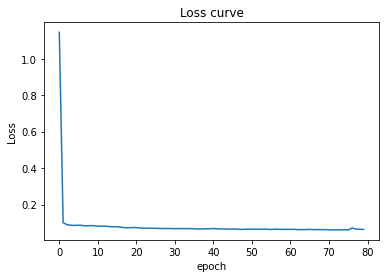

In [18]:
show_curve(loss, 'Loss')

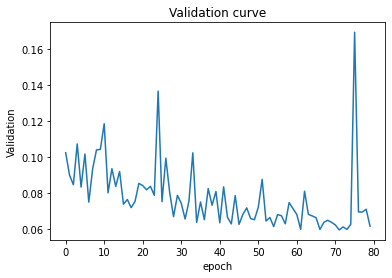

In [19]:
show_curve(correct, 'Validation')

In [33]:
fresh_model = ColorizationNet().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(fresh_model.parameters(), lr=lr, weight_decay=0.0)

In [34]:
loss_f, correct_f = train(fresh_model, optimizer, criterion, fresh_train_loader, fresh_val_loader, fresh_home)

Epoch 0: (0 / 18): Model loss = 15.842
Epoch 0: (10 / 18): Model loss = 10.912
Epoch 0: Model loss = 7.137, Validation loss = 19.074
Epoch 1: (0 / 18): Model loss = 0.531
Epoch 1: (10 / 18): Model loss = 0.471
Epoch 1: Model loss = 0.416, Validation loss = 0.360
Epoch 2: (0 / 18): Model loss = 0.347
Epoch 2: (10 / 18): Model loss = 0.309
Epoch 2: Model loss = 0.290, Validation loss = 0.347
Epoch 3: (0 / 18): Model loss = 0.237
Epoch 3: (10 / 18): Model loss = 0.241
Epoch 3: Model loss = 0.242, Validation loss = 0.198
Epoch 4: (0 / 18): Model loss = 0.235
Epoch 4: (10 / 18): Model loss = 0.237
Epoch 4: Model loss = 0.241, Validation loss = 0.300
Epoch 5: (0 / 18): Model loss = 0.244
Epoch 5: (10 / 18): Model loss = 0.298
Epoch 5: Model loss = 0.281, Validation loss = 0.182
Epoch 6: (0 / 18): Model loss = 0.296
Epoch 6: (10 / 18): Model loss = 0.280
Epoch 6: Model loss = 0.274, Validation loss = 0.181
Epoch 7: (0 / 18): Model loss = 0.223
Epoch 7: (10 / 18): Model loss = 0.240
Epoch 7: M

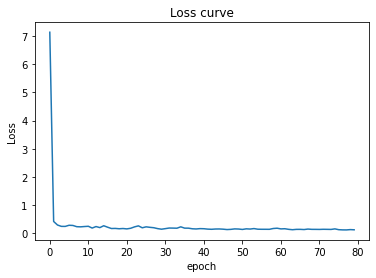

In [35]:
show_curve(loss_f, 'Loss')

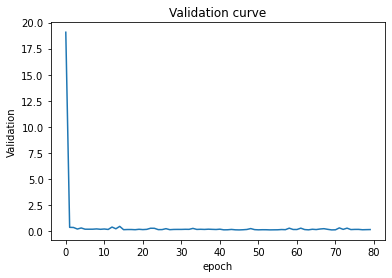

In [36]:
show_curve(correct_f, 'Validation')

## Testing

In [37]:
def show_result(model, loader, rows=3, cols=3):
    images, labels = next(iter(loader))
    images = images.to(device)
    labels = labels.to(device)
    outputs = model(images)
    figure = plt.figure(figsize=(8, 8))
    for i in range(1, cols + 1):
        image = images[i].to('cpu')
        label = labels[i].to('cpu')
        output = outputs[i].to('cpu')
        test_predict = concat_lab_to_rgb(image, output)
        figure.add_subplot(rows, cols, i)
        plt.title('Gray')
        plt.imshow(image.permute(1, 2, 0).squeeze(axis=2), cmap='gray')
        plt.axis("off")
        figure.add_subplot(rows, cols, i + cols)
        plt.title('Label')
        plt.imshow(concat_lab_to_rgb(image, label))
        plt.axis("off")
        figure.add_subplot(rows, cols, i + cols * 2)
        plt.title('Prediction')
        plt.imshow(concat_lab_to_rgb(image, output))
        plt.axis("off")
    plt.savefig(landscape_home+'prediction.jpg')
    plt.show()

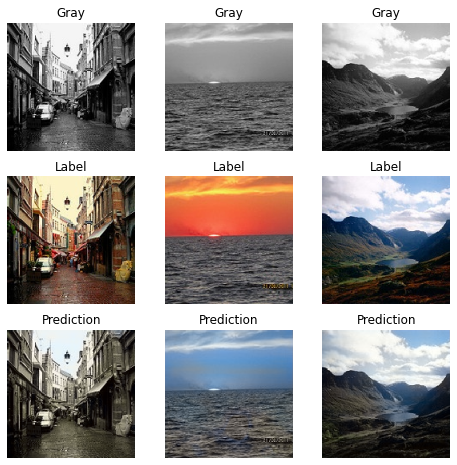

In [39]:
model.load_state_dict(torch.load(landscape_home+'model_70'))
show_result(model, landscape_test_loader)

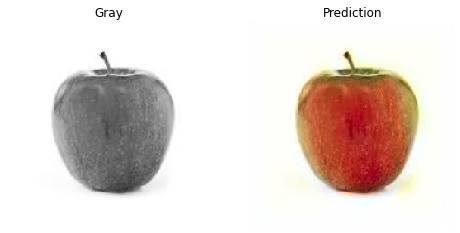

In [43]:
fresh_model.load_state_dict(torch.load(fresh_home+'model_79'))
images = next(iter(fresh_test_loader))
images = images.to(device)
outputs = fresh_model(images).to(device)

fig = plt.figure(figsize=(8, 8))
image = images[0].to('cpu')
output = outputs[0].to('cpu')
test_predict = concat_lab_to_rgb(image, output)

fig.add_subplot(1, 2, 1)
plt.title('Gray')
plt.axis("off")
plt.imshow(image.permute(1, 2, 0).squeeze(axis=2), cmap='gray')

fig.add_subplot(1, 2, 2)
plt.title('Prediction')
plt.axis("off")
plt.imshow(concat_lab_to_rgb(image, output))

plt.savefig(fresh_home+'Prediction-Fresh.jpg')
plt.show()